# Combined network: 

- PV-Pyr network --> Local network with self-supervised learning 

- SST-Pyr netork --> Global network with supervised learning


TODO:
- find this SST input ?

- Quantify learning: ablation of specific inputs or total specific areas
- Drop off of some units in specific areas or layers for example

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Dataset

In [2]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [3]:
from modules.network import CombinedNetwork
# from skimage.metrics import structural_similarity as ssim
import numpy as np

lr = 0.001
momentum = 0.5


model = CombinedNetwork(thal_input_dim=784, td_input_dim = 784, latent_dim = 128 ,topdown_dim = 128, output_dim=10)
#optimizer = optim.SGD(model.parameters(), lr=lr,momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn = nn.MSELoss()

print(model)

CombinedNetwork(
  (PV): PV(
    (flatten): Flatten()
    (fc1): Linear(in_features=784, out_features=784, bias=True)
    (activation): Sigmoid()
    (fc2): Linear(in_features=784, out_features=128, bias=True)
  )
  (SST): SST(
    (flatten): Flatten()
    (fc1): Linear(in_features=784, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=784, bias=True)
    (fc3): Linear(in_features=784, out_features=128, bias=True)
    (activation): Sigmoid()
  )
  (Pyr): PyrCombined(
    (activation): Sigmoid()
    (flatten): Flatten()
    (fc1): Linear(in_features=128, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
  (Decoder): Decoder(
    (fc1): Linear(in_features=10, out_features=784, bias=True)
  )
)


In [4]:
for name, param in model.named_parameters():
    print (name)

PV.fc1.weight
PV.fc1.bias
PV.fc2.weight
PV.fc2.bias
SST.fc1.weight
SST.fc1.bias
SST.fc2.weight
SST.fc2.bias
SST.fc3.weight
SST.fc3.bias
Pyr.fc1.weight
Pyr.fc1.bias
Pyr.fc2.weight
Pyr.fc2.bias
Pyr.fc3.weight
Pyr.fc3.bias
Decoder.fc1.weight
Decoder.fc1.bias


### Train & test

In [5]:
from modules.utils import calculate_ssim, weight_update, loss_combined


num_epochs = 50
log_interval = 300

train_losses = []
train_pred_losses = []
train_recon_losses = []
train_global_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

def train(epoch, dataloader, model, optimizer, loss_fn):
    pred_loss_avg = 0
    recon_loss_avg = 0
    global_loss_avg = 0
    loss_avg = 0
    model.train() 
    for batch_idx, batch in enumerate(dataloader):
        inputPV, _ = batch
        inputPyr, target = batch  
        t = F.one_hot(target, num_classes=10).float()
        inputSST, _ = batch 
        optimizer.zero_grad()
        top_down, _, PV_pred, Pyr_pred, Pyr_out, recon = model(inputSST, inputPV, inputPyr)

        total_loss, global_loss, pred_loss, recon_loss = loss_combined(loss_fn, t, PV_pred, Pyr_pred, Pyr_out, recon, inputPyr)

        weight_update(model, optimizer, total_loss, recon_loss)
        #pred_loss_avg += pred_loss.item()
        recon_loss_avg += recon_loss.item()
        global_loss_avg += global_loss.item()
        loss_avg += total_loss.item()

        if batch_idx % log_interval == 0:
            train_losses.append(total_loss.item())
            #train_pred_losses.append(pred_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_global_losses.append(global_loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))

    recon_loss_avg, pred_loss_avg, global_loss_avg, loss_avg = (loss / len(dataloader) for loss in (recon_loss_avg, pred_loss_avg, global_loss_avg, loss_avg))
    print('Epoch: {} Pred_loss: {:.6f} Recon_loss: {:.6f} Global_loss: {:.6f}  Total loss: {:.6f}'.format(epoch, pred_loss_avg, recon_loss_avg, global_loss_avg, loss_avg))

def test(dataloader, model, loss_fn):
    model.eval()
    pred_loss_avg = 0
    recon_loss_avg = 0
    global_loss_avg = 0
    test_loss_avg = 0
    with torch.no_grad():
        for batch in dataloader:
            inputPV, _ = batch
            inputPyr, target = batch  
            t = F.one_hot(target, num_classes=10).float()
            inputSST, _ = batch 
            top_down, _, PV_pred, Pyr_pred, Pyr_out, recon  = model(inputSST, inputPV, inputPyr)

            total_loss, global_loss, pred_loss, recon_loss = loss_combined(loss_fn, t, PV_pred, Pyr_pred, Pyr_out, recon, inputPyr)
            #pred_loss_avg += pred_loss.item()
            recon_loss_avg += recon_loss.item()
            global_loss_avg += global_loss.item()
            test_loss_avg += total_loss.item()
            #ssim_score = calculate_ssim(recon, inputs)
            
    recon_loss_avg, pred_loss_avg, global_loss_avg, test_loss_avg = (loss / len(dataloader) for loss in (recon_loss_avg, pred_loss_avg, global_loss_avg, test_loss_avg))
    test_losses.append(test_loss_avg)
    print('Test set: Pred_loss: {:.6f}  Recon_loss: {:.6f} Global_loss: {:.6f} Total loss: {:.6f}\n'.format(pred_loss_avg, recon_loss_avg, global_loss_avg, test_loss_avg))
    


In [6]:
test(test_data_loader, model, loss_fn)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, optimizer, loss_fn)
  test(test_data_loader, model, loss_fn)

Test set: Pred_loss: 0.000000  Recon_loss: 1.124416 Global_loss: 0.272525 Total loss: 1.396941

Epoch: 1 Pred_loss: 0.000000 Recon_loss: 0.669394 Global_loss: 0.054613  Total loss: 0.724007
Test set: Pred_loss: 0.000000  Recon_loss: 0.533275 Global_loss: 0.036633 Total loss: 0.569908

Epoch: 2 Pred_loss: 0.000000 Recon_loss: 0.493605 Global_loss: 0.035371  Total loss: 0.528975
Test set: Pred_loss: 0.000000  Recon_loss: 0.460183 Global_loss: 0.036331 Total loss: 0.496514

Epoch: 3 Pred_loss: 0.000000 Recon_loss: 0.446193 Global_loss: 0.038851  Total loss: 0.485044
Test set: Pred_loss: 0.000000  Recon_loss: 0.427630 Global_loss: 0.041112 Total loss: 0.468742

Epoch: 4 Pred_loss: 0.000000 Recon_loss: 0.422349 Global_loss: 0.042772  Total loss: 0.465122
Test set: Pred_loss: 0.000000  Recon_loss: 0.409813 Global_loss: 0.044576 Total loss: 0.454389

Epoch: 5 Pred_loss: 0.000000 Recon_loss: 0.408493 Global_loss: 0.045533  Total loss: 0.454025
Test set: Pred_loss: 0.000000  Recon_loss: 0.39911

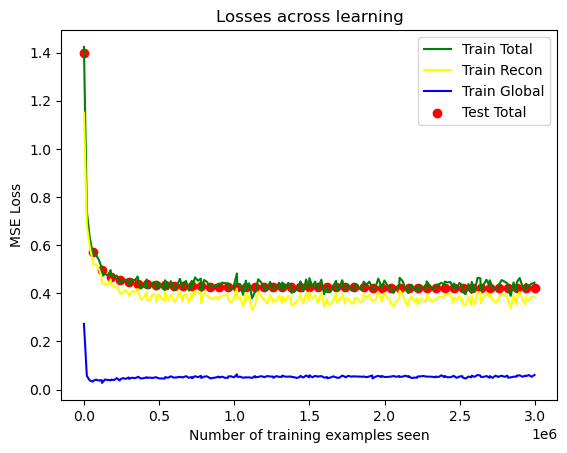

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green')
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train Global','Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('MSE Loss')
plt.title("Losses across learning")

plt.savefig('optADAM,lr0.001,betas0.9,0.999.png')